In [191]:
import os
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

IMAGE_SIZE = 32

class Dataset:
    
    def __init__(self, folder):
        self.positives = self.load_folder(os.path.join(folder, "pos"))
        self.negatives = self.load_folder(os.path.join(folder, "neg"))
        
        self.last_pos = 0
        self.last_neg = 0
        
    def load_folder(self, folder):
        images = []
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if not os.path.isfile(file_path):
                continue
                
            image = Image.open(file_path)
            image = image.convert('L').resize((IMAGE_SIZE, IMAGE_SIZE))
            image = (np.array(image) - 128.0) / 128.0
            images.append(image)
        return images
    
    def get_batch(self, batch_size):
        if self.last_pos + batch_size//2 > len(self.positives):
            self.last_pos = 0
            random.shuffle(self.positives)
            
        if self.last_neg + batch_size//2 > len(self.negatives):
            self.last_neg = 0
            random.shuffle(self.negatives)
        
        pos_images = self.positives[self.last_pos:(self.last_pos + batch_size//2)]
        neg_images = self.negatives[self.last_neg:(self.last_neg + batch_size//2)]
        
        pos_images = [np.flip(x, axis=1) if np.random.random() > 0.5 else x for x in pos_images]  
        
        pos_labels = [1] * (batch_size//2)
        neg_labels = [0] * (batch_size//2)
        
        self.last_pos = self.last_pos + batch_size//2 
        self.last_neg = self.last_neg + batch_size//2
        
        images = [item for sublist in zip(pos_images, neg_images) for item in sublist]
        data = np.dstack(images)
        data = data.transpose(2, 0, 1)
        data = data[:, np.newaxis, :, :]
        
        labels = np.array([item for sublist in zip(pos_labels, neg_labels) for item in sublist])
        labels = labels[:, np.newaxis, np.newaxis, np.newaxis]
        return data, labels
    
    def __str__(self):
        return "%d, %d" % (len(self.positives), len(self.negatives))
        
train = Dataset("/home/douwe/ball/data/train")
val = Dataset("/home/douwe/ball/data/val")

# train.negatives = train.negatives[:len(train.positives)]



print("Train:", str(train))
print("Val:  ", str(val))

Train: 1560, 44134
Val:   404, 11503


In [ ]:
for i in range(30):
    train.last_pos = 0
    train.last_neg = 0
    batch = train.get_batch(10)
    fig, plot = plt.subplots(1, 10)
    for j in range(10):
        plot[j].imshow(np.squeeze(batch[0][j]), cmap="gray")
        plot[j].set_axis_off()
    plt.show(fig)
    plt.close(fig)

In [198]:
import torch
from torch import nn

learning_rate = 0.001
BATCH_SIZE = 256
WEIGHT_DECAY = 0.01

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.nn.Sequential(
            torch.nn.BatchNorm2d(1),
            torch.nn.Conv2d(1, 64, 5, padding=2, stride=2), # 16
            torch.nn.LeakyReLU(), # 16
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 128, 5, padding=2, stride=2), # 8
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 1, 1, padding=1), # 16
            torch.nn.MaxPool2d(8),
            torch.nn.Sigmoid(),
        ).to(device)

def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight, 1.5)
        m.bias.data.fill_(0.02)

model.apply(init_weights)

loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)
losses = []
train_accuracies = []
val_accuracies = []
for t in range(10001):
    data, labels = train.get_batch(BATCH_SIZE)
#     print(data.shape)
#     print(sum(labels)/len(labels))
    x = torch.Tensor(data).to(device)
    y = torch.Tensor(labels).to(device)
    
#     print(model[0].weight)
    
#     fig, plot = plt.subplots(1, BATCH_SIZE, figsize=(15, 5))
#     for i in range(BATCH_SIZE):
#         plot[i].imshow(data[i, 0, :, :], cmap="gray")
#         plot[i].set_axis_off()
#         plot[i].set_title(np.squeeze(labels)[i])
#     plt.show(fig)
#     plt.close(fig)
    
#     print(x.shape, y.shape)
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
#     print(np.squeeze(y_pred.cpu().detach().numpy()))
#     break

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
#     print(loss.item())
    losses.append(loss.item())
#     print(y_pred.shape)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()
    
    if t % 500 == 0:
        print(t)
        model.eval()
        train_accuracies.append(get_accuracy(model, train, 0.5))
        val_accuracies.append(get_accuracy(model, val, 0.5))
        torch.save(model, "model_%d.pth" % t)
        model.train()

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


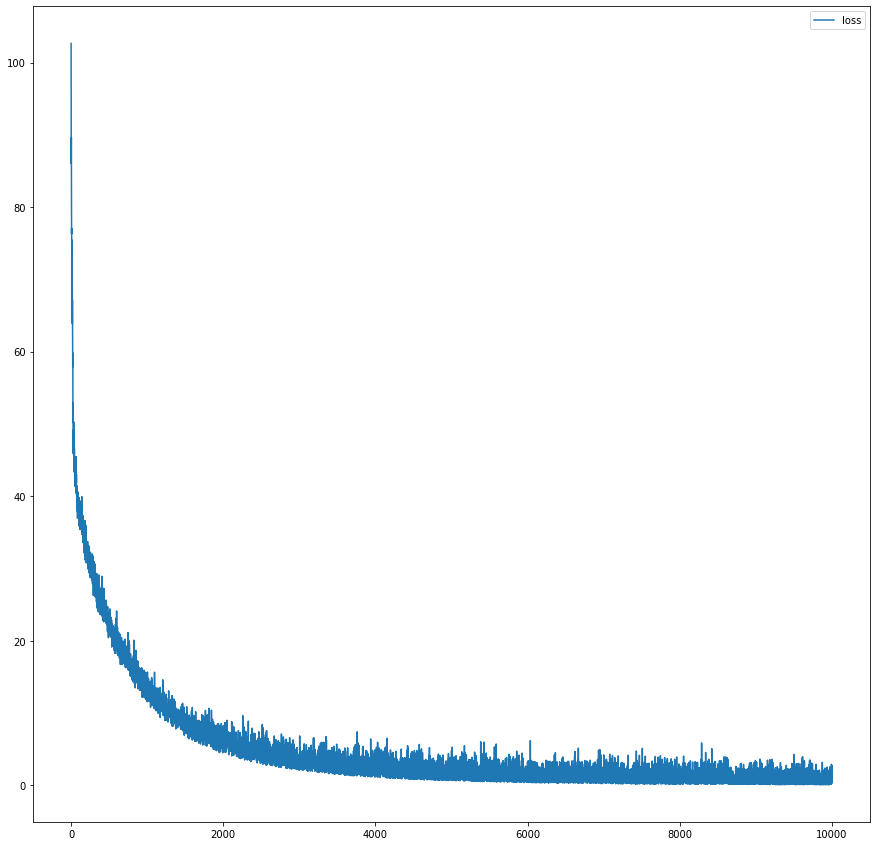

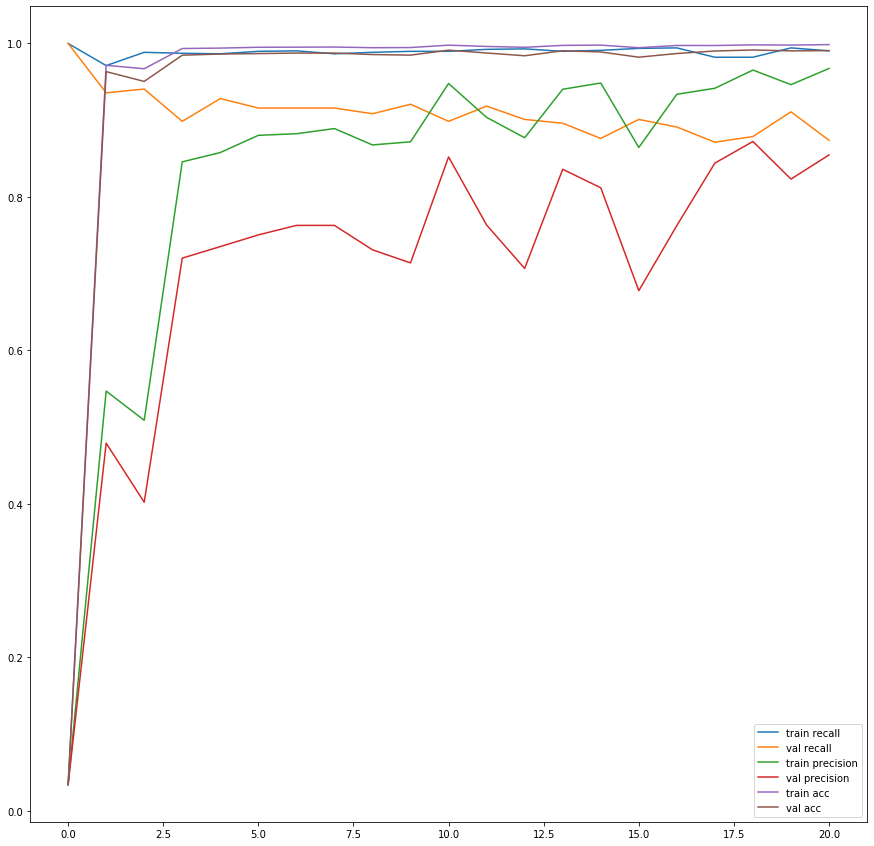

In [199]:
fig, plot = plt.subplots(1, 1, figsize=(15, 15))
plot.plot(range(len(losses)), losses, label="loss")
plt.legend()

fig, plot = plt.subplots(1, 1, figsize=(15, 15))
plot.plot(range(len(train_accuracies)), [x[0] for x in train_accuracies], label="train recall")
plot.plot(range(len(val_accuracies)), [x[0] for x in val_accuracies], label="val recall")

plot.plot(range(len(train_accuracies)), [x[1] for x in train_accuracies], label="train precision")
plot.plot(range(len(val_accuracies)), [x[1] for x in val_accuracies], label="val precision")

plot.plot(range(len(train_accuracies)), [x[2] for x in train_accuracies], label="train acc")
plot.plot(range(len(val_accuracies)), [x[2] for x in val_accuracies], label="val acc")
plot.legend()


In [200]:
tp = 0
fp = 0 
fn = 0
tn = 0

threshold = 0.5

model.eval()
for pos in val.positives:
    score = model(torch.Tensor(np.array(pos)[np.newaxis, np.newaxis, :, :]).to(device)).item()
    
    if score > threshold:
        tp += 1
    else:
        fn += 1

for neg in val.negatives:
    score = model(torch.Tensor(np.array(neg)[np.newaxis, np.newaxis, :, :]).to(device)).item()
    
    if score > threshold:
        fp += 1
    else:
        tn += 1
model.train()
        
print("Accuracy:  %.2f" % ((tp + tn) / (tp + tn + fn + fp)))
print("Recall:    %.2f" % (tp / (tp + fn)))
print("Precision: %.2f" % (tp / (tp + fp)))

Accuracy:  0.99
Recall:    0.87
Precision: 0.85


In [162]:
def get_accuracy(model, dataset, threshold):
    tp = 0
    fp = 0 
    fn = 0
    tn = 0

    for pos in dataset.positives:
        score = model(torch.Tensor(np.array(pos)[np.newaxis, np.newaxis, :, :]).to(device)).item()
    
        if score > threshold:
            tp += 1
        else:
            fn += 1

    for neg in dataset.negatives:
        score = model(torch.Tensor(np.array(neg)[np.newaxis, np.newaxis, :, :]).to(device)).item()

        if score > threshold:
            fp += 1
        else:
            tn += 1

    recall = (tp / (tp + fn))
    precision =  (tp / (tp + fp))
    accuracy = ((tp + tn) / (tp + tn + fn + fp))
    return recall, precision, accuracy

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


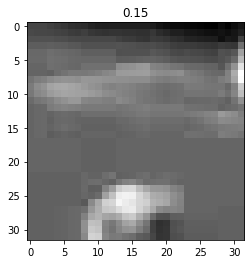

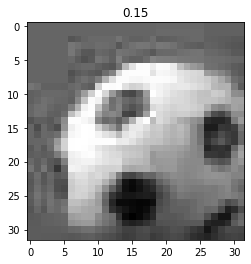

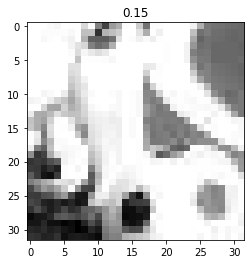

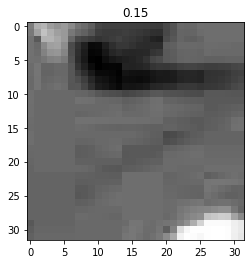

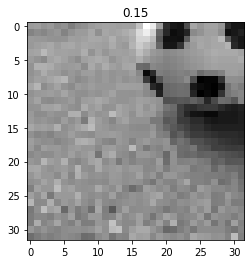

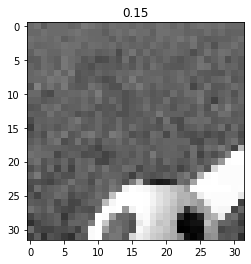

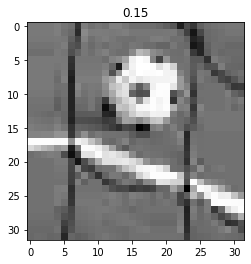

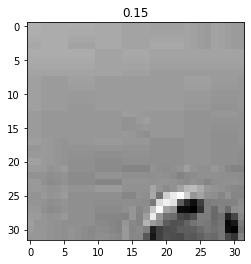

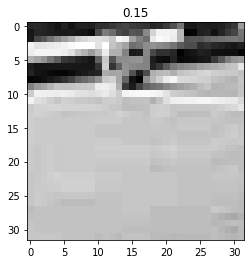

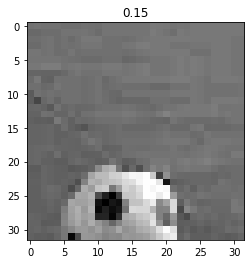

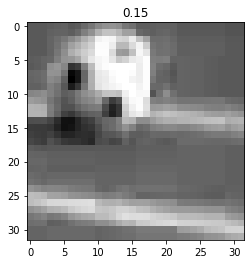

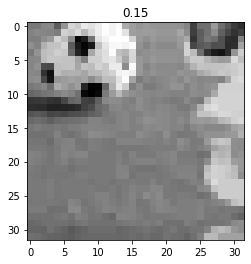

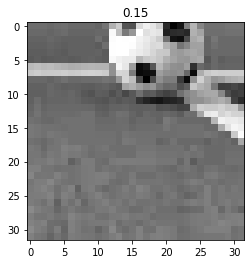

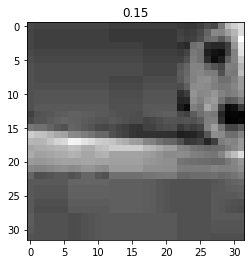

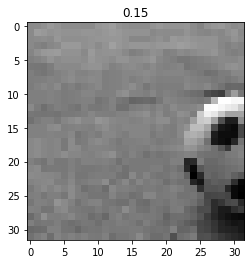

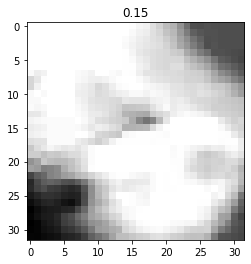

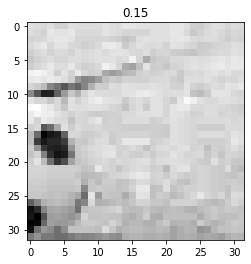

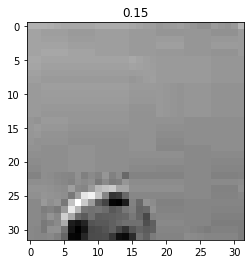

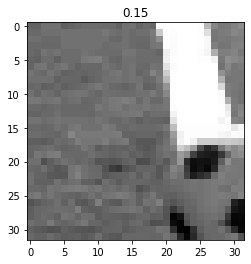

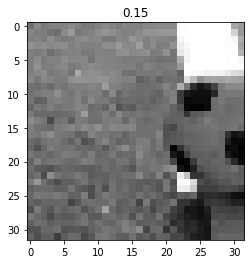

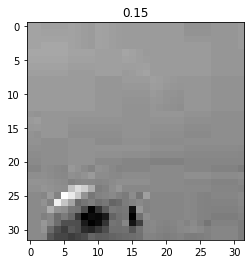

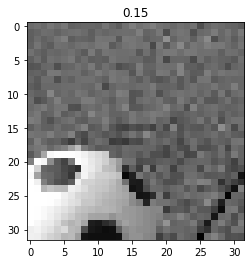

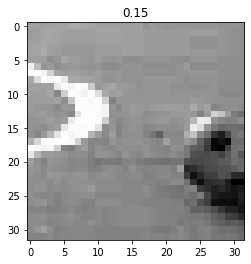

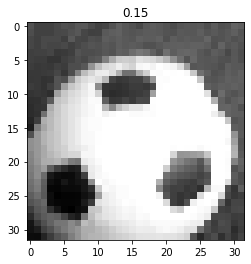

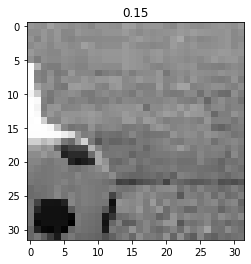

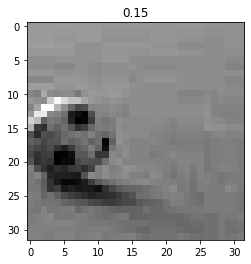

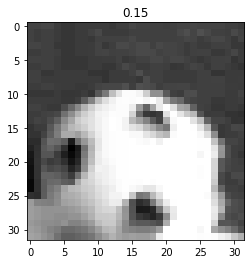

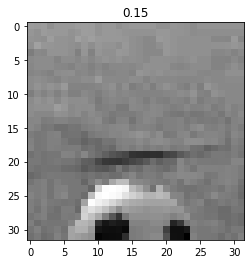

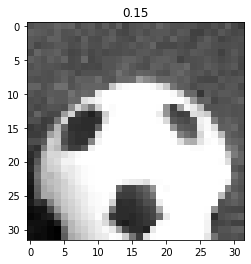

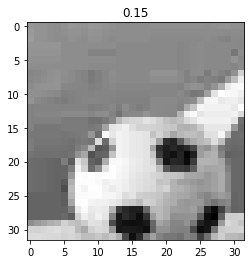

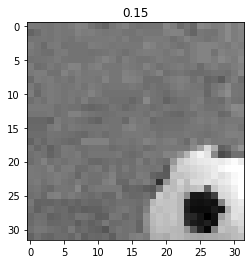

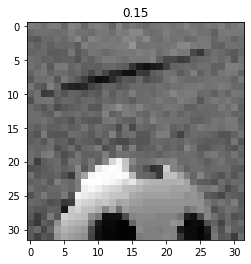

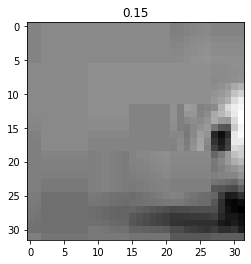

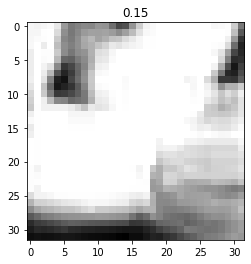

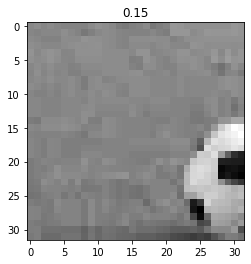

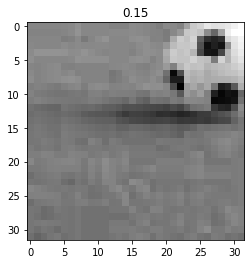

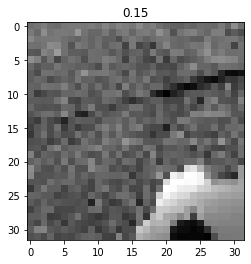

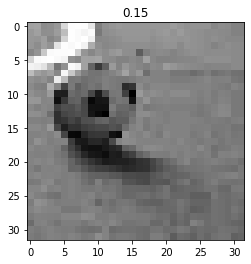

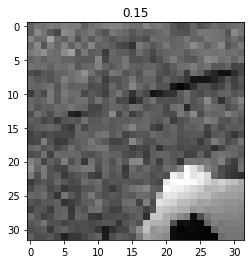

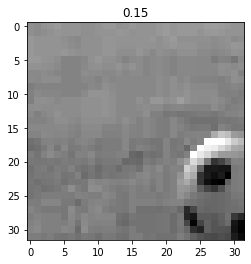

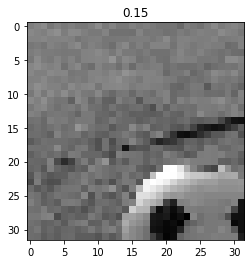

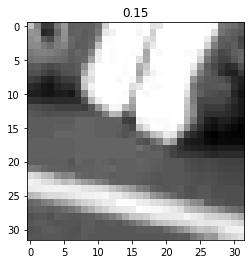

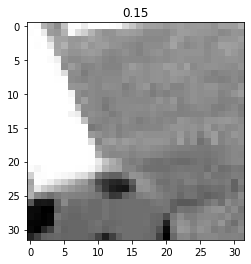

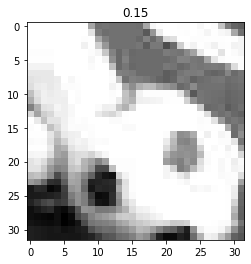

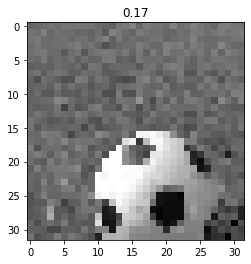

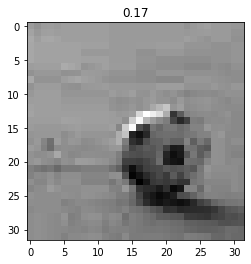

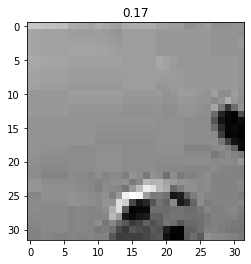

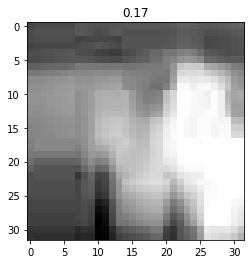

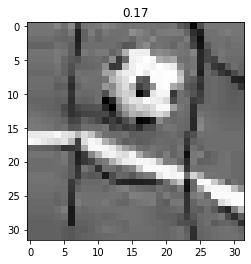

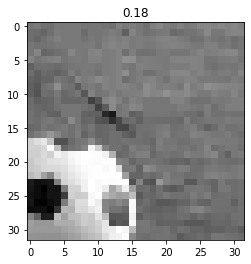

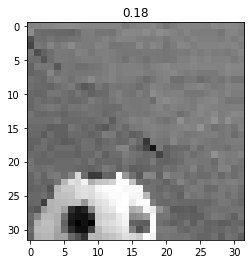

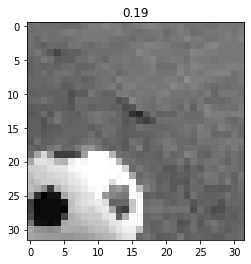

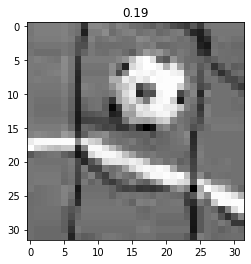

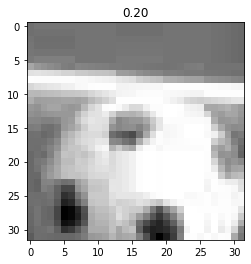

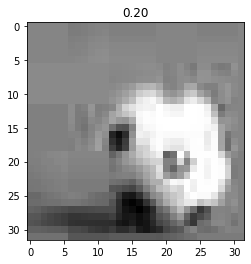

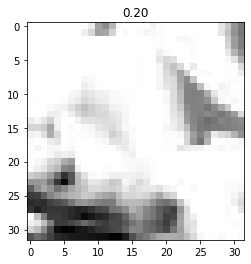

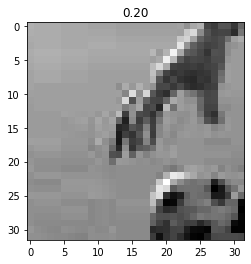

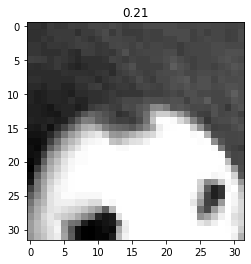

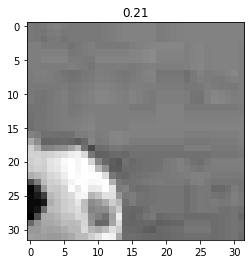

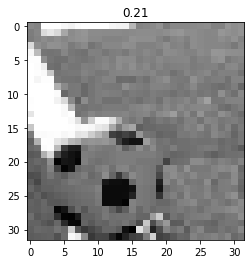

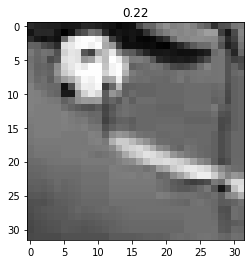

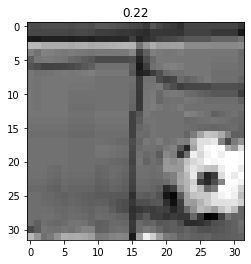

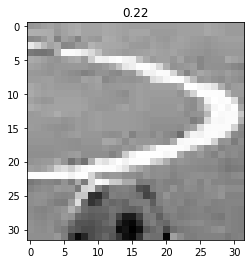

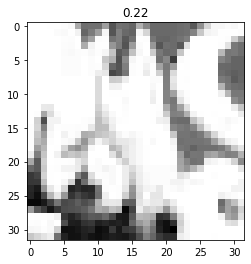

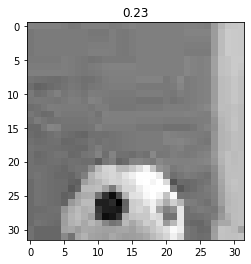

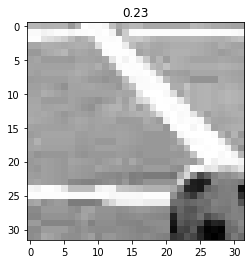

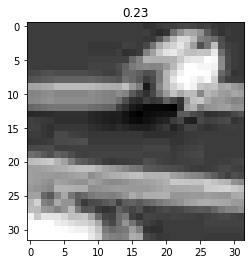

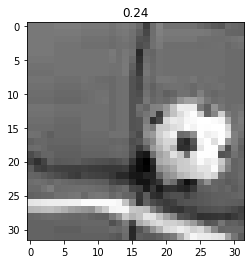

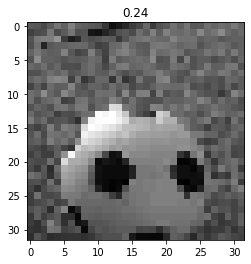

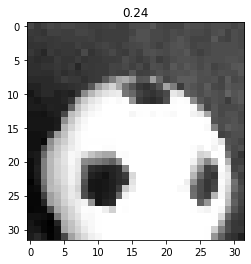

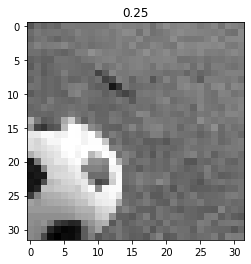

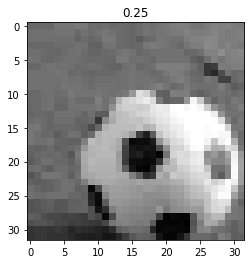

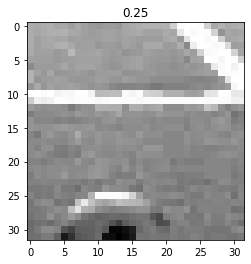

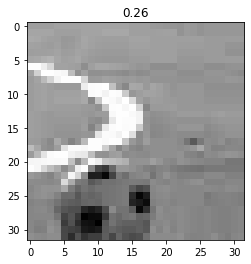

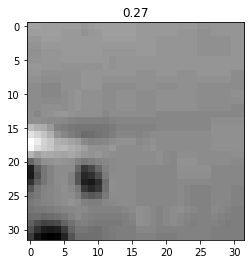

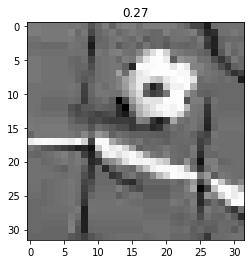

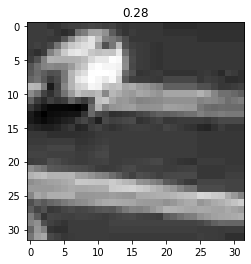

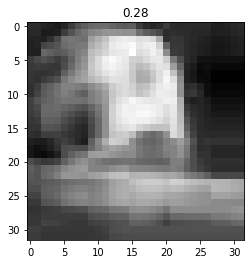

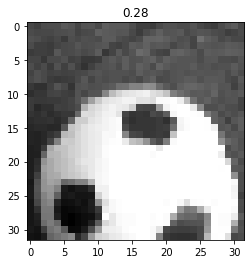

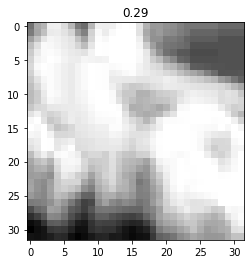

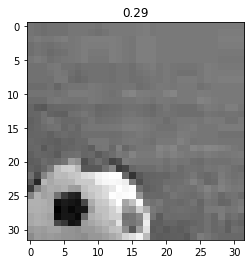

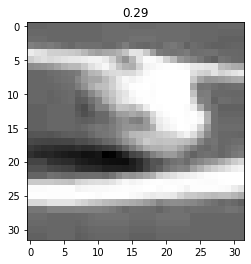

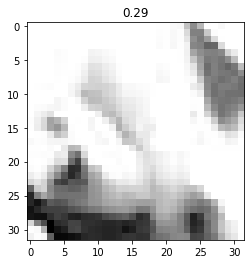

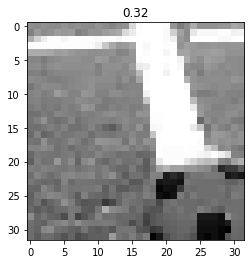

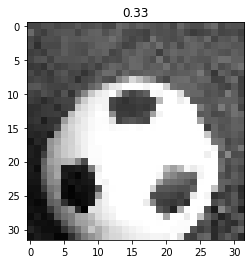

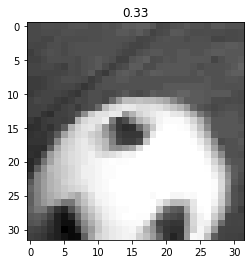

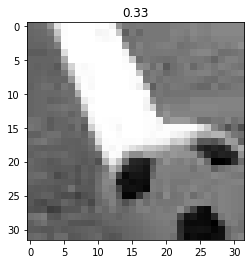

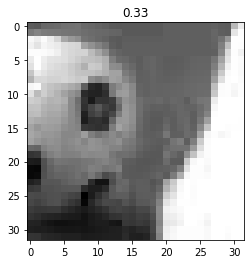

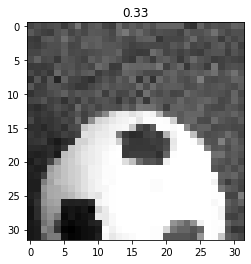

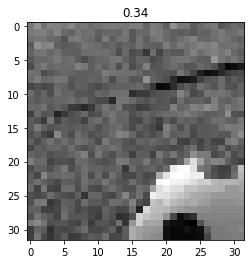

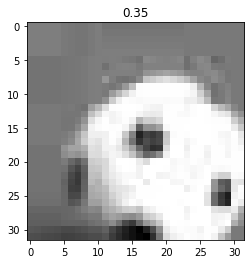

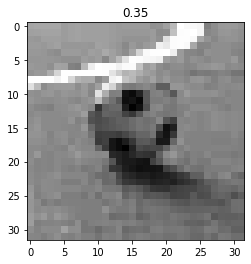

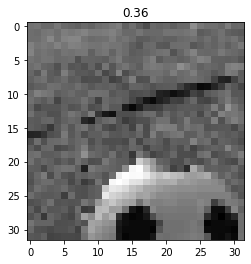

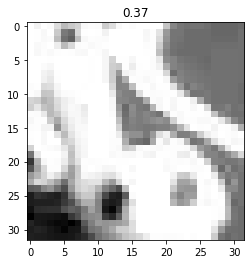

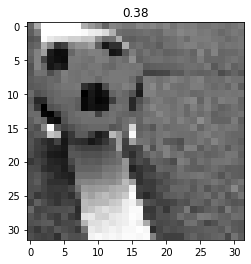

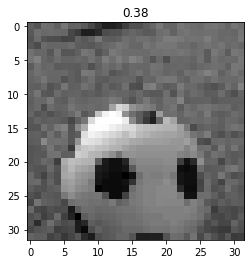

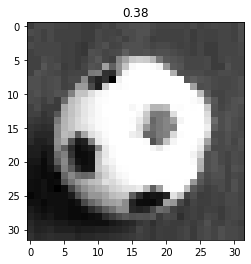

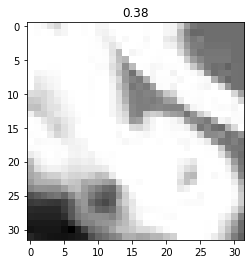

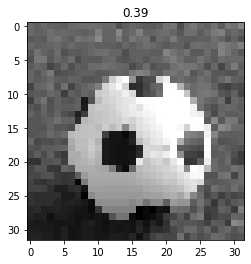

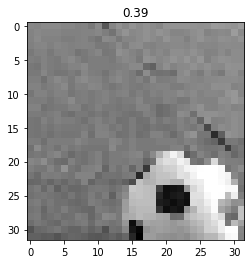

In [182]:

predictions = []
for data in val.positives:
    score = model(torch.Tensor(np.array(data)[np.newaxis, np.newaxis, :, :]).to(device)).item()
    predictions.append([score, data])
    
predictions = sorted(predictions, key=lambda x: x[0])

for prediction in predictions[:100]:
    score, data = prediction
    fig, plot = plt.subplots(1, 1)
    plot.imshow(data, cmap="gray")
    plot.set_title("%.2f" % score)
    plt.show(fig)
    plt.close(fig)

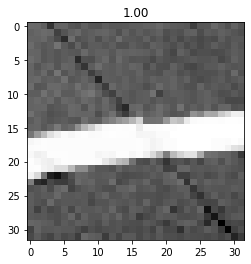

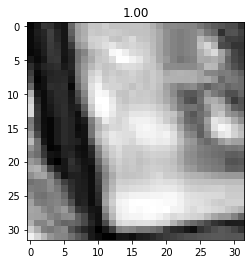

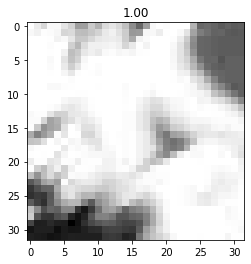

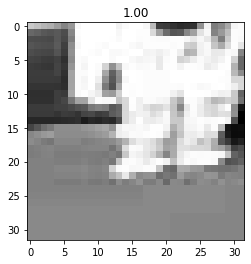

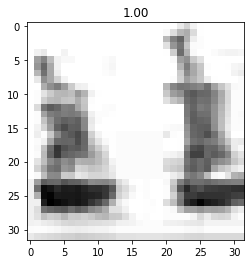

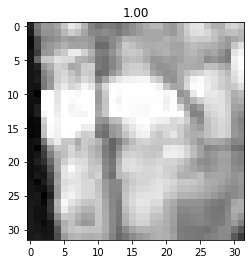

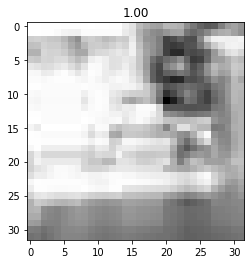

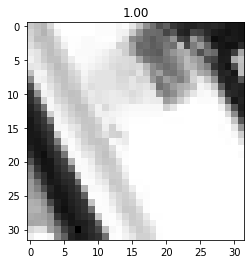

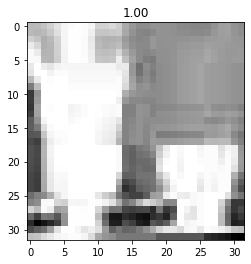

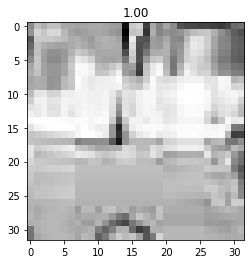

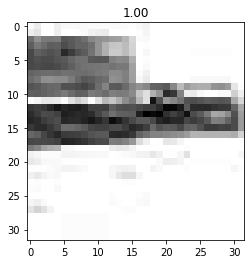

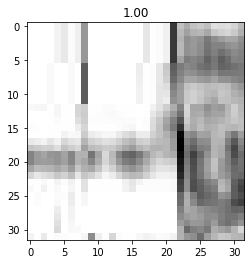

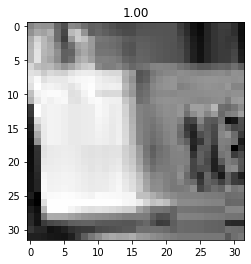

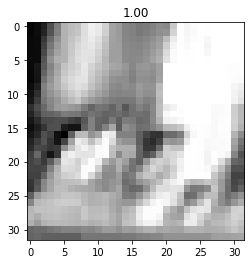

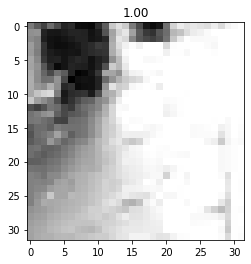

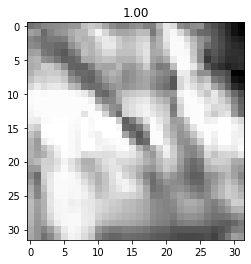

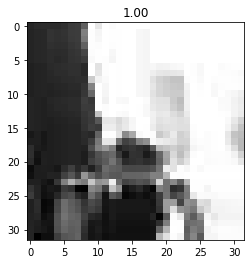

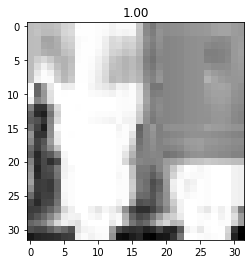

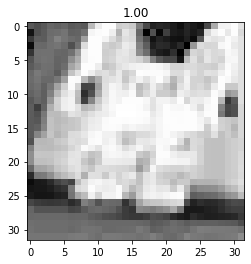

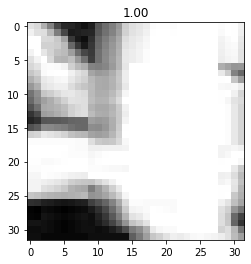

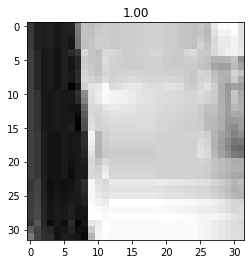

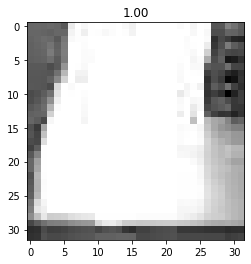

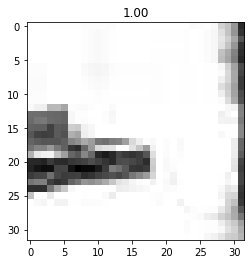

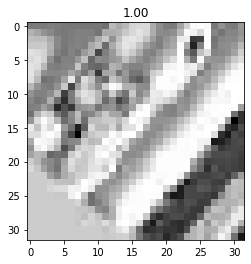

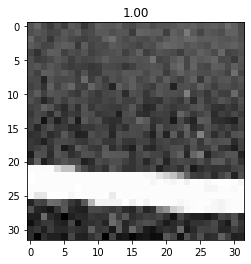

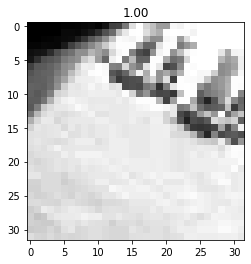

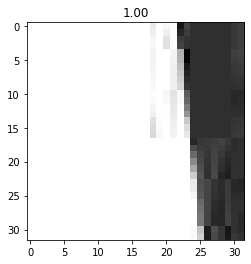

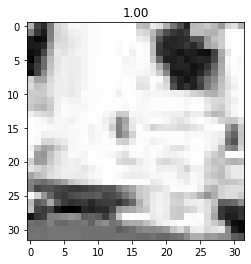

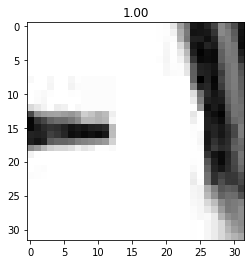

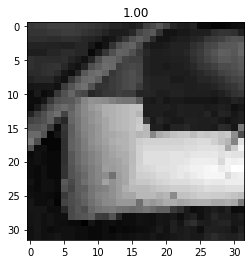

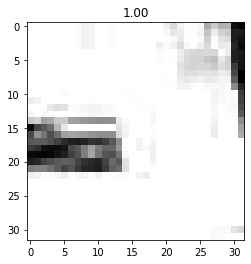

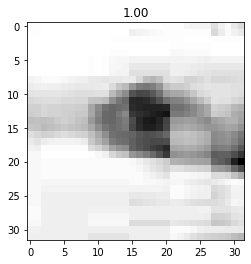

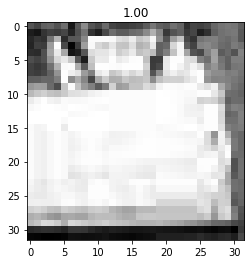

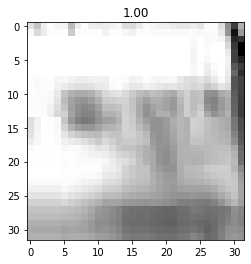

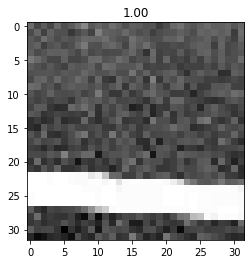

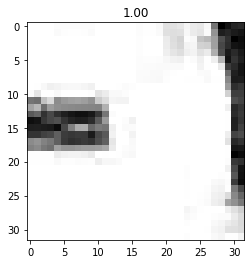

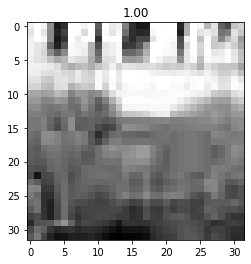

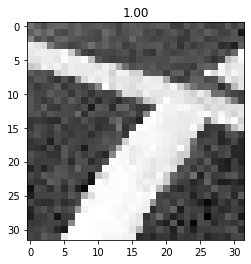

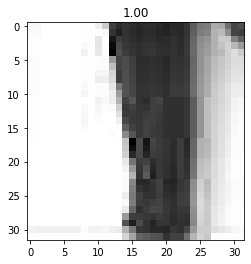

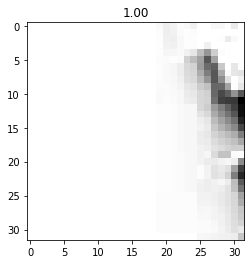

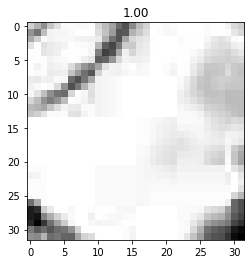

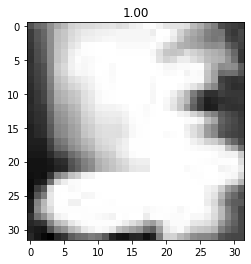

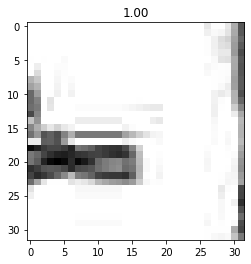

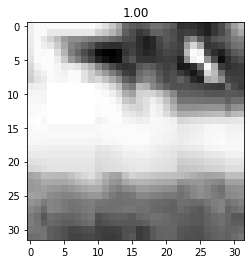

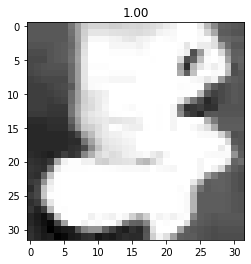

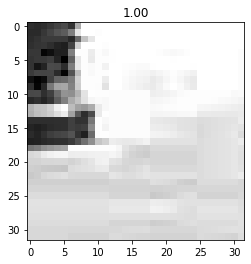

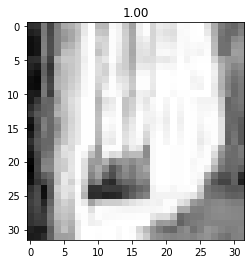

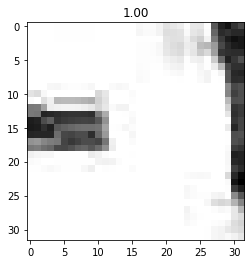

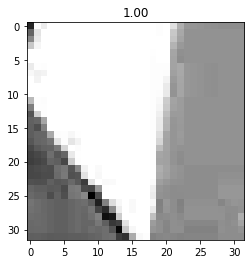

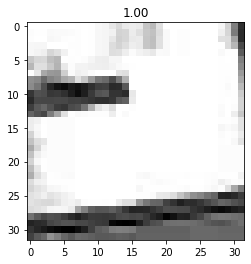

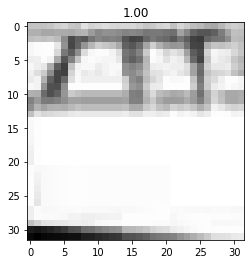

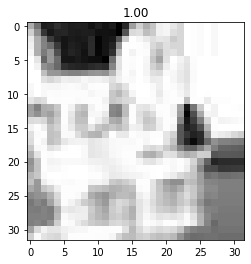

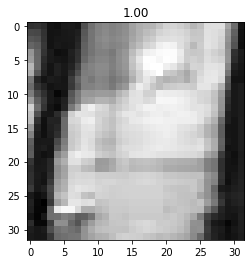

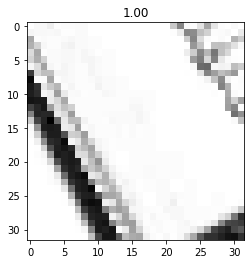

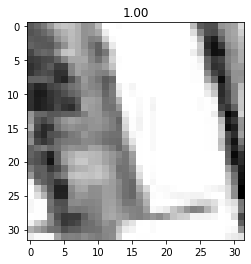

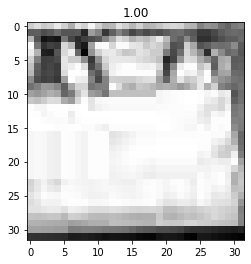

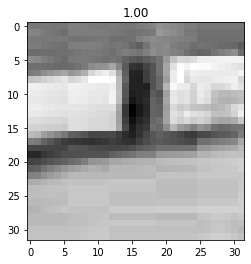

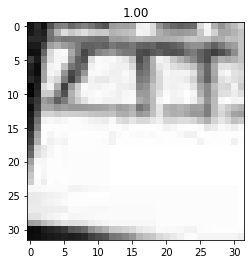

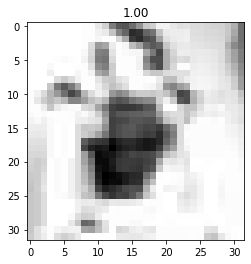

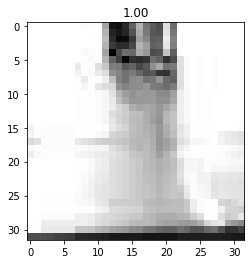

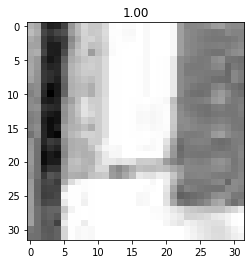

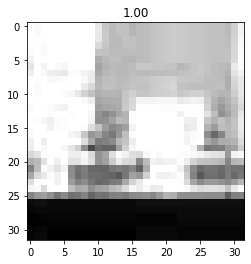

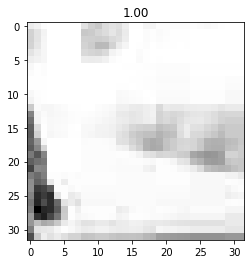

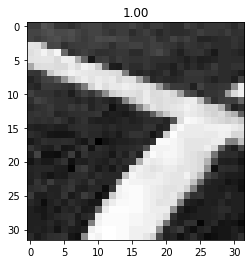

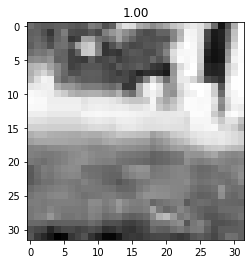

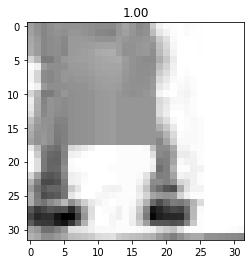

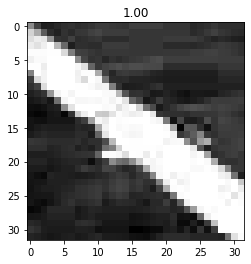

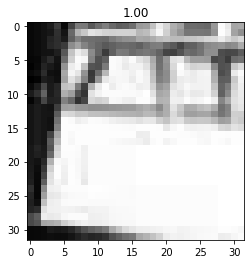

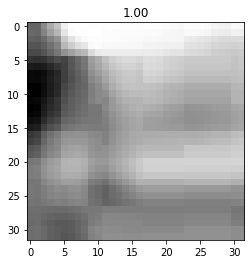

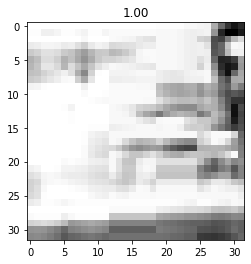

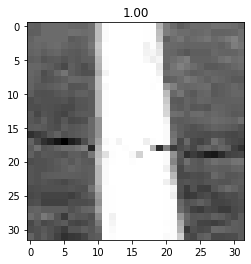

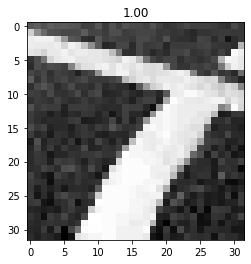

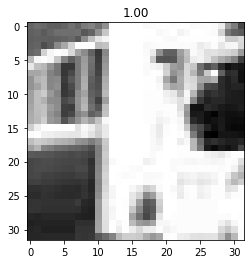

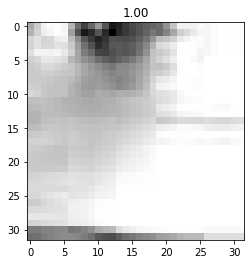

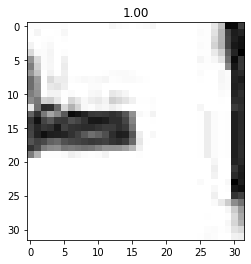

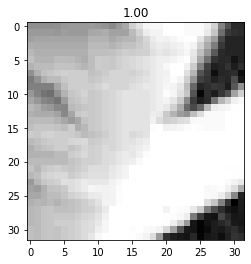

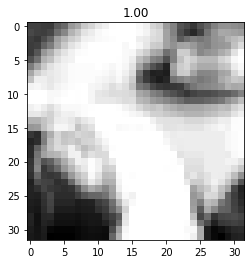

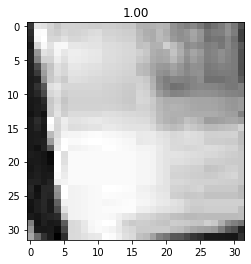

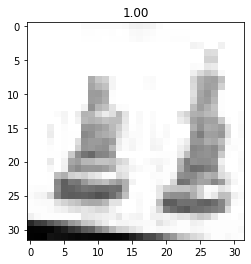

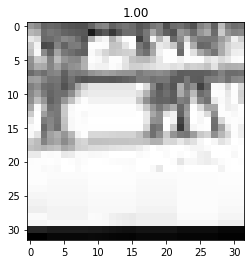

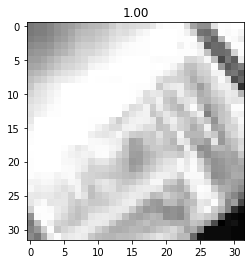

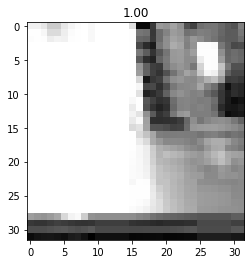

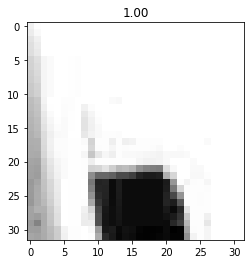

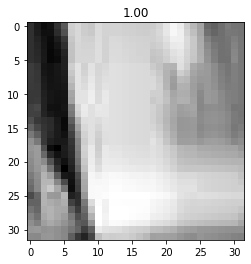

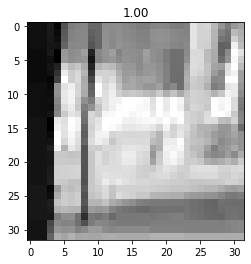

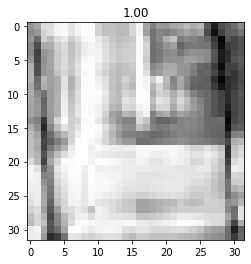

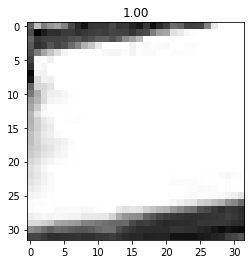

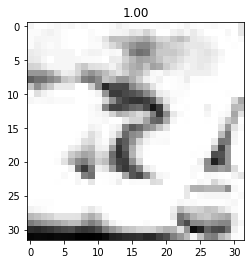

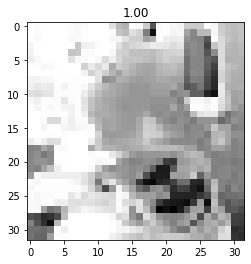

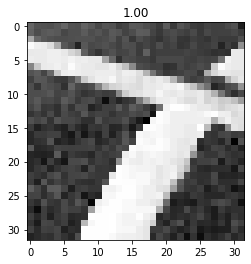

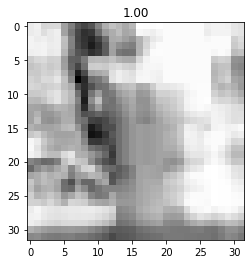

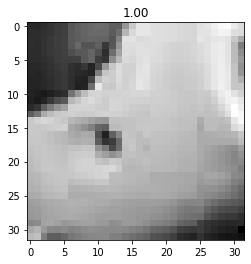

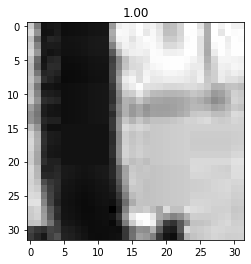

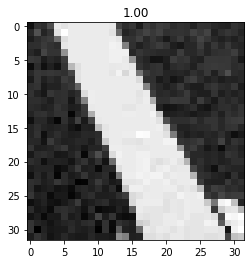

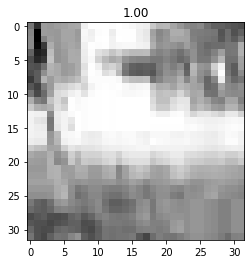

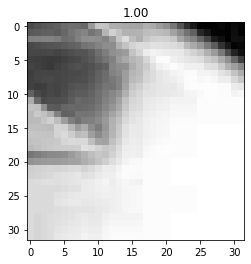

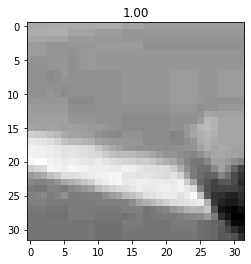

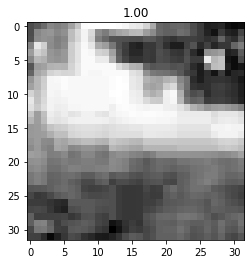

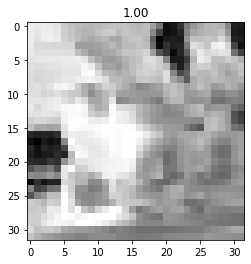

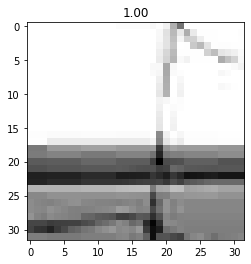

Sequential(
  (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): LeakyReLU(negative_slope=0.01)
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (5): LeakyReLU(negative_slope=0.01)
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (8): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (9): Sigmoid()
)

In [180]:
model.eval()
predictions = []
for data in val.negatives:
    score = model(torch.Tensor(np.array(data)[np.newaxis, np.newaxis, :, :]).to(device)).item()
    predictions.append([score, data])
    
predictions = sorted(predictions, key=lambda x: x[0], reverse=True)

for prediction in predictions[:100]:
    score, data = prediction
    fig, plot = plt.subplots(1, 1)
    plot.imshow(data, cmap="gray")
    plot.set_title("%.2f" % score)
    plt.show(fig)
    plt.close(fig)
model.train()